In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [2]:
dataset = NWBDataset('/home/dmifsud/Projects/NDT-U/data/mc_rtt_train.nwb')
dataset.resample(10)

In [3]:
smooth_std = 50 #ms
lag = 120 #ms

In [4]:
vel_trans = dataset.data.finger_vel.to_numpy().T # idx 0 is x; idx 1 is y
hi_spikes_trans = dataset.data.spikes.to_numpy().T
ho_spikes_trans = dataset.data.heldout_spikes.to_numpy().T

In [5]:
def seg_arr(data):
    # shape of data: T (time) x C (channels)
    tmp_list = []
    for channel in data:
        tmp_list.append([channel[seg] for seg in np.ma.clump_unmasked(np.ma.masked_invalid(channel))])
    return np.transpose(np.array(tmp_list), (1, 2, 0))

In [6]:
vel_segments = seg_arr(vel_trans)
hi_spike_segments = seg_arr(hi_spikes_trans)
ho_spike_segments = seg_arr(ho_spikes_trans)
print(vel_segments.shape)
print(hi_spike_segments.shape)
print(ho_spike_segments.shape)

(4, 16220, 2)
(4, 16220, 98)
(4, 16220, 32)


In [7]:
def chop_data(data, chopsize, overlap):
    chopped_data = []
    for trial in data:
        shape = (
            int((trial.shape[0] - overlap) / (chopsize - overlap)),
            chopsize,
            trial.shape[-1],
        )
        strides = (
            trial.strides[0] * (chopsize - overlap),
            trial.strides[0],
            trial.strides[1],
        )
        chopped_trial = np.lib.stride_tricks.as_strided(trial, shape=shape, strides=strides).copy().astype('f')
        chopped_data.append(chopped_trial)
    chopped_data = np.array(chopped_data)
    return chopped_data.reshape((
        chopped_data.shape[0] * chopped_data.shape[1], 
        chopped_data.shape[2], 
        chopped_data.shape[3]
    ))

In [8]:
train_hi_segments_29 = chop_data(hi_spike_segments[:3], 30, 29)
train_ho_segments_29 = chop_data(ho_spike_segments[:3], 30, 29)

print(train_hi_segments_29.shape)
print(train_ho_segments_29.shape)

train_hi_segments_27 = chop_data(hi_spike_segments[:3], 30, 27)
train_ho_segments_27 = chop_data(ho_spike_segments[:3], 30, 27)

print(train_hi_segments_27.shape)
print(train_ho_segments_27.shape)

train_hi_segments_24 = chop_data(hi_spike_segments[:3], 30, 24)
train_ho_segments_24 = chop_data(ho_spike_segments[:3], 30, 24)

print(train_hi_segments_24.shape)
print(train_ho_segments_24.shape)

(48573, 30, 98)
(48573, 30, 32)
(16191, 30, 98)
(16191, 30, 32)
(8097, 30, 98)
(8097, 30, 32)


In [9]:
test_hi_segments = chop_data(np.expand_dims(hi_spike_segments[3], 0), 30, 29)
test_ho_segments = chop_data(np.expand_dims(ho_spike_segments[3], 0), 30, 29)
print(test_hi_segments.shape)
print(test_ho_segments.shape)

(16191, 30, 98)
(16191, 30, 32)


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_hi_segments_24.shape

(8097, 30, 98)

In [12]:
hi_spike_segments[:3].shape

(3, 16220, 98)

In [13]:

hi_segs = train_hi_segments_24
ho_segs = train_ho_segments_24

train_hi_segments, val_hi_segments = train_test_split(
    hi_segs, test_size=0.2, random_state=42)

train_ho_segments, val_ho_segments = train_test_split(
    ho_segs, test_size=0.2, random_state=42)

print(train_hi_segments.shape)
print(val_hi_segments.shape)
print(train_ho_segments.shape)
print(val_ho_segments.shape)

(6477, 30, 98)
(1620, 30, 98)
(6477, 30, 32)
(1620, 30, 32)


In [14]:
import os
import h5py
import os.path as osp
from nlb_tools.make_tensors import save_to_h5, h5_to_dict

In [44]:

with h5py.File('/home/dmifsud/Projects/NDT-U/data/mc_rtt_cont_24.h5', 'r') as h5file:
    h5dict = h5_to_dict(h5file)

In [36]:
np.zeros((train_hi_segments.shape[0], 1, 130)).shape

(6477, 1, 130)

In [15]:
train_dict = {
    'train_spikes_all_fp': np.zeros((train_hi_segments.shape[0], 1, 130)),
    'train_spikes_heldin': train_hi_segments,
    'train_spikes_heldout': train_ho_segments
}

In [16]:
val_dict = {
    'eval_spikes_all_fp': np.zeros((val_hi_segments.shape[0], 1, 130)),
    'eval_spikes_heldin': val_hi_segments,
    'eval_spikes_heldout': val_ho_segments
}

In [17]:
trainval_dict = {
    'trainval_spikes_all_fp': np.zeros((hi_segs.shape[0], 1, 130)),
    'trainval_spikes_heldin': hi_segs,
    'trainval_spikes_heldout': ho_segs
}

In [18]:
test_dict = {
    'test_spikes_heldin': test_hi_segments,
    'test_spikes_heldout': test_ho_segments
}

In [51]:
for i in h5dict.keys():
    print(i, h5dict[i].shape)

eval_spikes_all_fp (1620, 1, 130)
eval_spikes_heldin (1620, 30, 98)
eval_spikes_heldout (1620, 30, 32)
test_spikes_heldin (16191, 30, 98)
train_spikes_all_fp (6477, 1, 130)
train_spikes_heldin (6477, 30, 98)
train_spikes_heldout (6477, 30, 32)
trainval_spikes_all_fp (8097, 1, 130)
trainval_spikes_heldin (8097, 30, 98)
trainval_spikes_heldout (8097, 30, 32)


In [ ]:
eval_spikes_all_fp = np.array()

In [50]:
h5_file = {**train_dict, **val_dict, **trainval_dict, **test_dict}
filename = 'data/' + 'mc_rtt_cont' + '.h5'
# Remove older version if it exists
if osp.isfile(filename): os.remove(filename)
save_to_h5(h5_file, filename, overwrite=True)

In [19]:
kern_sd = int(round(smooth_std / dataset.bin_width))
window = signal.gaussian(kern_sd * 6, kern_sd, sym=True)
window /= np.sum(window)
filt = lambda x: np.convolve(x, window, 'same')

In [22]:
hi_spike_segments[:3].shape

(3, 16220, 98)

In [32]:
for i in hi_spike_segments[:3]:
    print(np.apply_along_axis(filt, 0, i).shape)
    print(np.apply_along_axis(filt, 0, i)[:5, :])

(16220, 98)
[[0.         0.04368646 0.         0.         0.         0.03014513
  0.         0.00882014 0.         0.         0.         0.14708124
  0.         0.         0.         0.         0.07060057 0.
  0.         0.         0.         0.         0.00119368 0.03436498
  0.         0.         0.07060057 0.         0.         0.
  0.         0.         0.         0.07648068 0.         0.
  0.         0.         0.00208974 0.06261708 0.         0.05455244
  0.         0.003515   0.         0.         0.         0.
  0.00882014 0.         0.14865201 0.         0.         0.
  0.         0.         0.07648068 0.         0.         0.
  0.         0.         0.         0.06261708 0.00328341 0.
  0.         0.13484189 0.         0.         0.01315811 0.
  0.         0.         0.06261708 0.         0.         0.
  0.         0.         0.15139616 0.0188599  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.05335876 0.         0.16420442

In [106]:
dataset.data[smth_field].shape

(64910, 98)

In [53]:
lag = 120
lag_bins = int(round(lag / dataset.bin_width))
nans = dataset.data.finger_vel.x.isna().reset_index(drop=True)
rates = dataset.data.spikes_smth_50[~nans.to_numpy() & ~nans.shift(-lag_bins, fill_value=True).to_numpy()].to_numpy()
spikes = dataset.data.spikes[~nans.to_numpy() & ~nans.shift(-lag_bins, fill_value=True).to_numpy()].to_numpy()
vel = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].to_numpy()
vel_index = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].index

In [54]:
spikes.shape

(64838, 98)

In [118]:
dataset.data.spikes_smth_50.shape

(64910, 98)

In [117]:
dataset.data.spikes_smth_50[~dataset.data.spikes_smth_50.isna().reset_index(drop=True).to_numpy()]

channel,301,401,701,802,901,1001,1002,1103,1202,1301,...,8701,8801,8901,9103,9201,9203,9403,9501,9502,9601
clock_time,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:10:49.090000,0.0,0.000000,0.076481,0.0,0.0,0.000000,0.0,0.00209,0.0,0.0,...,0.0,0.0,0.074116,0.0,0.000000,0.003515,0.000000,0.068298,0.00882,0.000000
0 days 00:10:49.090000,0.0,0.000000,0.076481,0.0,0.0,0.000000,0.0,0.00209,0.0,0.0,...,0.0,0.0,0.074116,0.0,0.000000,0.003515,0.000000,0.068298,0.00882,0.000000
0 days 00:10:49.090000,0.0,0.000000,0.076481,0.0,0.0,0.000000,0.0,0.00209,0.0,0.0,...,0.0,0.0,0.074116,0.0,0.000000,0.003515,0.000000,0.068298,0.00882,0.000000


In [119]:
dataset.data.spikes_smth_50[~dataset.data.spikes_smth_50.isna().to_numpy()]

channel,301,401,701,802,901,1001,1002,1103,1202,1301,...,8701,8801,8901,9103,9201,9203,9403,9501,9502,9601
clock_time,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
0 days 00:00:00,0.0,0.043686,0.000000,0.0,0.0,0.030145,0.0,0.00882,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.053359,0.000000,0.164204,0.000000,0.00000,0.025972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:10:49.090000,0.0,0.000000,0.076481,0.0,0.0,0.000000,0.0,0.00209,0.0,0.0,...,0.0,0.0,0.074116,0.0,0.000000,0.003515,0.000000,0.068298,0.00882,0.000000
0 days 00:10:49.090000,0.0,0.000000,0.076481,0.0,0.0,0.000000,0.0,0.00209,0.0,0.0,...,0.0,0.0,0.074116,0.0,0.000000,0.003515,0.000000,0.068298,0.00882,0.000000
0 days 00:10:49.090000,0.0,0.000000,0.076481,0.0,0.0,0.000000,0.0,0.00209,0.0,0.0,...,0.0,0.0,0.074116,0.0,0.000000,0.003515,0.000000,0.068298,0.00882,0.000000


In [51]:
rates.shape

(64838, 98)

In [ ]:
lag = 120
lag_bins = int(round(lag / dataset.bin_width))
nans = dataset.data.finger_vel.x.isna().reset_index(drop=True)
rates = dataset.data.spikes_smth_50[~nans.to_numpy() & ~nans.shift(-lag_bins, fill_value=True).to_numpy()].to_numpy()
vel = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].to_numpy()
vel_index = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].index

In [63]:
test = dataset.data.finger_vel.x[:5]
test

clock_time
0 days 00:00:00           0.691476
0 days 00:00:00.010000    1.537992
0 days 00:00:00.020000    1.550475
0 days 00:00:00.030000    1.799469
0 days 00:00:00.040000    1.903062
Freq: 10L, Name: x, dtype: float64

In [70]:
shifted = test.shift(-2)
shifted

clock_time
0 days 00:00:00           1.550475
0 days 00:00:00.010000    1.799469
0 days 00:00:00.020000    1.903062
0 days 00:00:00.030000         NaN
0 days 00:00:00.040000         NaN
Freq: 10L, Name: x, dtype: float64

In [71]:
nans = shifted.isna().reset_index(drop=True)
nans

0    False
1    False
2    False
3     True
4     True
Name: x, dtype: bool

In [73]:
shifted[~nans.to_numpy()]

clock_time
0 days 00:00:00           1.550475
0 days 00:00:00.010000    1.799469
0 days 00:00:00.020000    1.903062
Freq: 10L, Name: x, dtype: float64

In [36]:
dataset.data.spikes.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [37]:
import numpy as np
nan = np.nan

def using_clump(a):
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

In [56]:
arr = dataset.data.spikes.to_numpy().T
arr = spikes.T

In [57]:
split_data = using_clump(arr)

In [58]:
arr.shape

(98, 64838)

In [59]:

test=[]
for i in arr:
    test.append(using_clump(i))

In [60]:
np.array(test).shape

(98, 1, 64838)

In [43]:
new_arr = np.transpose(test, (1, 2, 0))

In [44]:
new_arr.shape

(4, 16220, 98)

In [33]:
new_arr

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtyp

648549


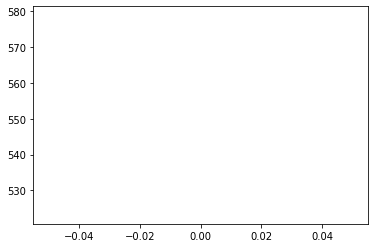

In [15]:
has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
# Find if target pos change corresponds to NaN-padded gap between files
change_nan = dataset.data[has_change].isna().any(axis=1)
print(len(has_change[has_change == True]))
plt.plot(len(change_nan))
plt.show()


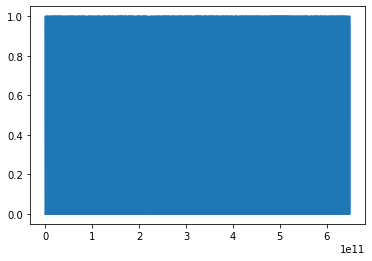

In [5]:
plt.plot(has_change)
plt.show()


In [ ]:
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
drop_trial = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True))[:-1]
# Add start and end times to trial info
change_times = dataset.data.index[has_change]
start_times = change_times[:-1][~drop_trial]
end_times = change_times[1:][~drop_trial]
# Get target position per trial
target_pos = dataset.data.target_pos.loc[start_times].to_numpy().tolist()
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

In [6]:
dataset.resample(5)

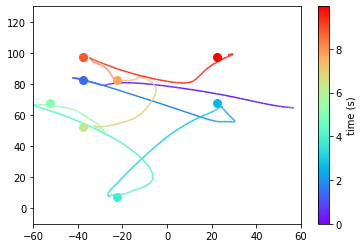

In [10]:
## Plot a few reaches

# Extract start and end times, target positions
start = dataset.trial_info.iloc[0].start_time # arbitrarily using 1st through 6th reaches
end = dataset.trial_info.iloc[7].end_time - pd.Timedelta(1, 'ms')
targets = dataset.trial_info.target_pos.iloc[0:8].to_numpy().tolist()
tts = dataset.trial_info.end_time.iloc[0:8] - start

# Get cursor position data
reach_data = dataset.data.cursor_pos.loc[start:end].to_numpy().reshape(-1, 1, 2)
reach_seg = np.concatenate([reach_data[:-1], reach_data[1:]], axis=1)
# Split into collection of lines for color gradient
lc = LineCollection(reach_seg, cmap='rainbow', norm=plt.Normalize(0, len(reach_seg) * dataset.bin_width / 1000))
lc.set_array(np.arange(len(reach_seg)) * dataset.bin_width / 1000)

# Plot lines and add targets
ax = plt.axes()
lines = ax.add_collection(lc)
for tt, target in zip(tts, targets):
    ax.plot(target[0], target[1], marker='o', markersize=8, color=plt.get_cmap('rainbow')(tt.total_seconds() * 1000 / dataset.bin_width / len(reach_seg)))
ax.set_xlim(-60, 60)
ax.set_ylim(-10, 130)
plt.colorbar(lines, label='time (s)')
plt.show()

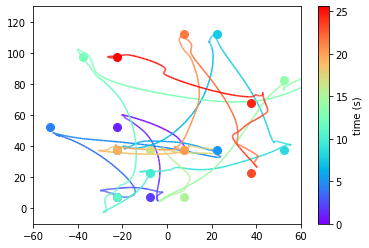

In [14]:
## Plot a few reaches

# Extract start and end times, target positions
start = dataset.trial_info.iloc[20].start_time # arbitrarily using 1st through 6th reaches
end = dataset.trial_info.iloc[40].end_time - pd.Timedelta(1, 'ms')
targets = dataset.trial_info.target_pos.iloc[20:41].to_numpy().tolist()
tts = dataset.trial_info.end_time.iloc[20:41] - start

# Get cursor position data
reach_data = dataset.data.cursor_pos.loc[start:end].to_numpy().reshape(-1, 1, 2)
reach_seg = np.concatenate([reach_data[:-1], reach_data[1:]], axis=1)
# Split into collection of lines for color gradient
lc = LineCollection(reach_seg, cmap='rainbow', norm=plt.Normalize(0, len(reach_seg) * dataset.bin_width / 1000))
lc.set_array(np.arange(len(reach_seg)) * dataset.bin_width / 1000)

# Plot lines and add targets
ax = plt.axes()
lines = ax.add_collection(lc)
for tt, target in zip(tts, targets):
    ax.plot(target[0], target[1], marker='o', markersize=8, color=plt.get_cmap('rainbow')(tt.total_seconds() * 1000 / dataset.bin_width / len(reach_seg)))
ax.set_xlim(-60, 60)
ax.set_ylim(-10, 130)
plt.colorbar(lines, label='time (s)')
plt.show()